<a href="https://colab.research.google.com/github/svnesh/MachineLearning/blob/master/song_viewing_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
inputPath = "/content/drive/My Drive/song_viewing_prediction/Inputs"
train_input = os.path.join(inputPath, "Data_Train.csv")
test_input = os.path.join(inputPath, "Data_Test.csv")

In [5]:
df_train_orig = pd.read_csv(train_input)

In [6]:
df_train = pd.read_csv(train_input)
df_test = pd.read_csv(test_input)

In [7]:
print('Training shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Training shape:  (78458, 11)
Test shape:  (19615, 10)


In [8]:
df_train.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Views,Comments,Likes,Popularity,Followers
0,413890,Hardstyle,danceedm,AU,N-Vitral presents BOMBSQUAD - Poison Spitter (...,2018-03-30 15:24:45.000000,14017,4,499,97,119563
1,249453,Dj Aladdin,danceedm,AU,Dj Aladdin - Old School Hip Hop Quick Mix,2016-06-20 05:58:52.000000,1918,17,49,17,2141
2,681116,Maxximize On Air,danceedm,AU,Maxximize On Air - Mixed by Blasterjaxx - Epis...,2015-05-08 17:45:59.000000,9668,11,312,91,22248
3,387253,GR6 EXPLODE,rbsoul,AU,MC Yago - Tenho Compromisso (DJ R7),2017-06-08 23:50:03.000000,113036,2,"2,400",76,393655
4,1428029,Tritonal,danceedm,AU,Escape (feat. Steph Jones),2016-09-17 20:50:19.000000,110024,81,"3,031",699,201030


In [9]:
df_test.head()

,Unique_ID,Name,Genre,Country,Song_Name,Timestamp,Comments,Likes,Popularity,Followers
0,562546,L2Share♫79,all-music,AU,엔플라잉 N.Flying - Rooftop (옥탑방),2019-01-02 09:49:19.000000,26,"5,428",118,2568
1,907584,Morgan Page,danceedm,AU,Morgan Page - In The Air - Episode 246,2015-03-09 17:30:10.000000,18,738,195,155645
2,213013,Dirty Workz,danceedm,AU,Outlander - Devotion (Official HQ Preview),2013-09-18 16:09:03.000000,18,386,96,29446
3,340312,Gucci Mane,all-music,AU,Freaky Gurl,2007-08-14 00:00:00.000000,1,388,19,799410
4,41854,Angga Kecap,rock,AU,Radical Nusantara - Teman,2018-08-10 16:28:54.000000,0,79,1,2


In [10]:
df_train.describe()

,Unique_ID,Views,Comments,Followers
count,7.845800e+04,7.845800e+04,78458.000000,7.845800e+04
mean,7.451701e+05,5.469686e+05,115.270973,4.787663e+05
std,4.805507e+05,3.883085e+06,724.614868,1.168120e+06
min,0.000000e+00,0.000000e+00,0.000000,1.000000e+00
25%,3.149512e+05,6.216500e+03,1.000000,1.770000e+04
50%,6.618655e+05,2.538650e+04,12.000000,8.768200e+04
75%,1.176618e+06,1.201342e+05,61.000000,3.936550e+05
max,1.570012e+06,1.994050e+08,104082.000000,9.789123e+06


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unique_ID   78458 non-null  int64 
 1   Name        78458 non-null  object
 2   Genre       78458 non-null  object
 3   Country     78458 non-null  object
 4   Song_Name   78457 non-null  object
 5   Timestamp   78458 non-null  object
 6   Views       78458 non-null  int64 
 7   Comments    78458 non-null  int64 
 8   Likes       78458 non-null  object
 9   Popularity  78458 non-null  object
 10  Followers   78458 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 6.6+ MB


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19615 entries, 0 to 19614
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unique_ID   19615 non-null  int64 
 1   Name        19615 non-null  object
 2   Genre       19615 non-null  object
 3   Country     19615 non-null  object
 4   Song_Name   19615 non-null  object
 5   Timestamp   19615 non-null  object
 6   Comments    19615 non-null  int64 
 7   Likes       19615 non-null  object
 8   Popularity  19615 non-null  object
 9   Followers   19615 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 1.5+ MB


In [13]:
df_train.nunique(axis=0)

Unique_ID     78458
Name           1209
Genre            21
Country           1
Song_Name     78457
Timestamp     68187
Views         53964
Comments       2152
Likes          9214
Popularity     5719
Followers      1153
dtype: int64

In [14]:
df_test.nunique(axis=0)

Unique_ID     19615
Name           1115
Genre            21
Country           1
Song_Name     19615
Timestamp     17810
Comments       1123
Likes          5415
Popularity     2989
Followers      1081
dtype: int64

In [15]:
df_train['singer_song_count'] = df_train.groupby(['Name'])['Song_Name'].transform('count')
df_train['singer_genre_count'] = df_train.groupby(['Name'])['Genre'].transform('count')

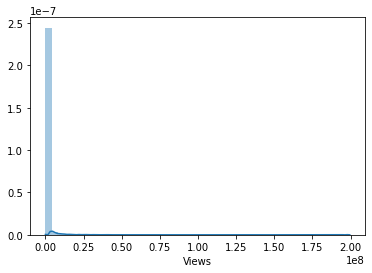

In [16]:
sns.distplot(df_train['Views'])

In [17]:
df_train['Views'] = np.log1p(df_train['Views'])

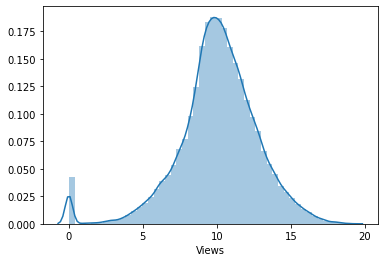

In [18]:
sns.distplot(df_train['Views'])

In [19]:
def getTimedetails(df1):
  df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
  df1['Year'] = df1['Timestamp'].dt.year
  df1['Month'] = df1['Timestamp'].dt.month
  df1['DayofWeek'] = df1['Timestamp'].dt.dayofweek
  df1['Hour'] = df1['Timestamp'].dt.hour
  df1['Minute'] = df1['Timestamp'].dt.minute
  df1['Second'] = df1['Timestamp'].dt.second
  del df1['Timestamp']
  return df1
df_train = getTimedetails(df_train)
df_test = getTimedetails(df_test)

In [20]:
def cleanNumber(value1):
  value1 = str(value1).strip()
  if re.match(r"^(\d*.?\d+?)K$", value1):
    return int(float(re.sub(r"^(\d*.?\d+?)K$", r"\1", value1))*1000)
  elif re.match(r"^(\d*.?\d+?)M$", value1):
    return int(float(re.sub(r"^(\d*.?\d+?)M$", r"\1", value1))*1000000)
  elif re.match(r"^(\d*),(\d+)$", value1):
    return int(re.sub(r"^(\d*),(\d+)$", r"\1\2", value1))
  else:
    return int(value1)

In [21]:
df_train.Likes = df_train['Likes'].apply(lambda x: cleanNumber(x))
df_test.Likes = df_test['Likes'].apply(lambda x: cleanNumber(x))
df_train.Popularity = df_train['Popularity'].apply(lambda x: cleanNumber(x))
df_test.Popularity = df_test['Popularity'].apply(lambda x: cleanNumber(x))

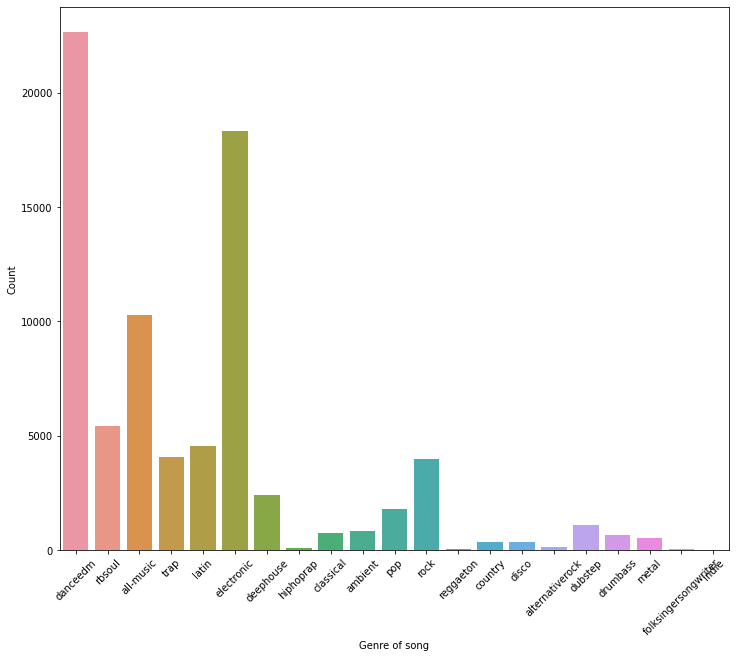

In [22]:
plt.figure(figsize=(12,10))
fig = sns.countplot(x='Genre', data=df_train)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
plt.xlabel('Genre of song')
plt.ylabel('Count')
plt.show()

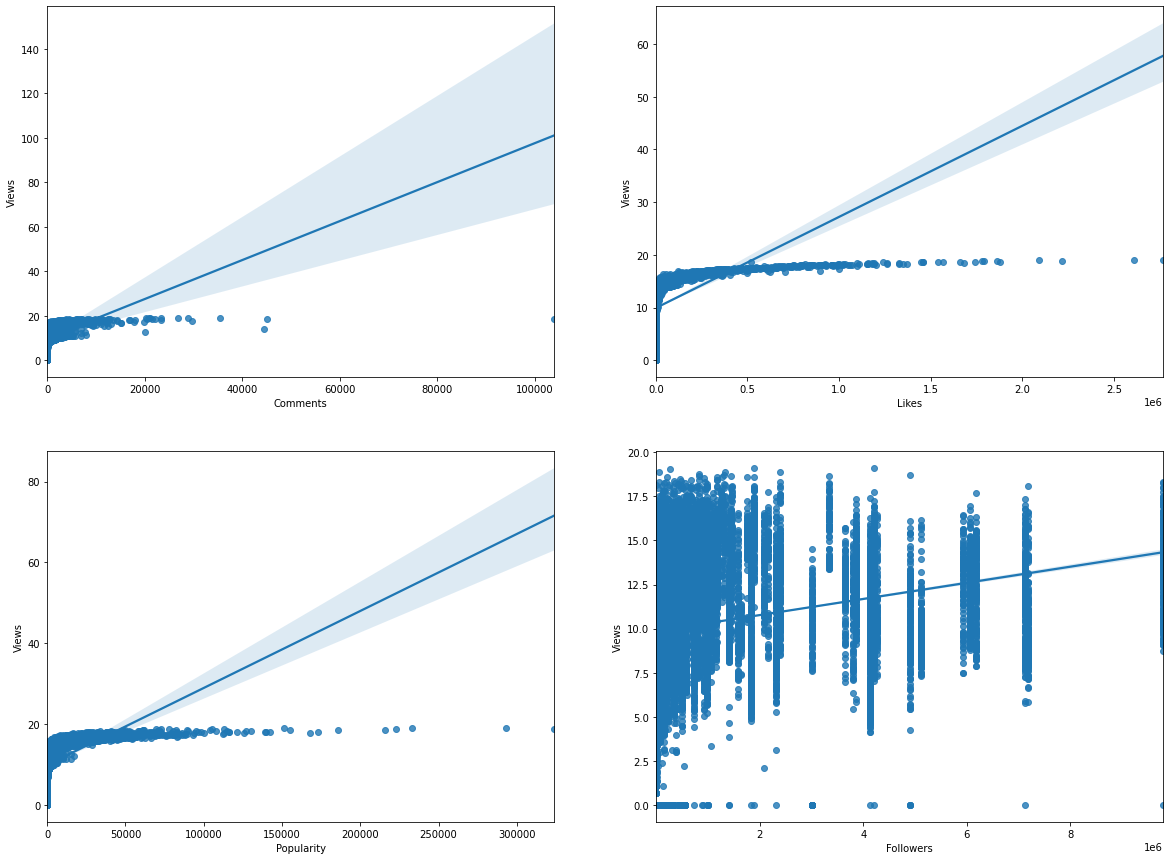

In [23]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.add_subplot(2,2,1)
g1 = sns.regplot("Comments", "Views", data=df_train)

fig.add_subplot(2,2,2)
g2 = sns.regplot("Likes", "Views", data=df_train)

fig.add_subplot(2,2,3)
g3 = sns.regplot("Popularity", "Views", data=df_train)

fig.add_subplot(2,2,4)
g4 = sns.regplot("Followers", "Views", data=df_train)

plt.show()

In [24]:
col_genre = pd.get_dummies(df_train['Genre'])

In [25]:
print('size before drop na {}'.format(df_train.shape))
df_train = pd.concat([df_train, col_genre], axis=1)

size before drop na (78458, 18)


In [26]:
#1 song name is nan
df_train.dropna(axis=0, inplace=True)
print('size after drop na {}'.format(df_train.shape))

size after drop na (78457, 39)


In [27]:
df_train = df_train.drop(columns=['Unique_ID'])
df_train = df_train.select_dtypes(exclude='object')
df_train.shape

(78457, 34)

In [28]:
#due to multi collinearity removed the below 2 cols
df_train.drop(columns=['Likes', 'Comments'], axis=1, inplace=True)

In [29]:
X = df_train.drop(columns=['Views'], axis=1)
y = df_train['Views']

In [30]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('total X shape {}'.format(X.shape))
print('Xtrain: {}'.format(X_train.shape))
print('Xtest: {}'.format(X_test.shape))
print('ytrain: {}'.format(y_train.shape))
print('ytest: {}'.format(y_test.shape))

total X shape (78457, 31)
Xtrain: (54919, 31)
Xtest: (23538, 31)
ytrain: (54919,)
ytest: (23538,)


In [32]:
df_train.columns

Index(['Views', 'Popularity', 'Followers', 'singer_song_count',
       'singer_genre_count', 'Year', 'Month', 'DayofWeek', 'Hour', 'Minute',
       'Second', 'all-music', 'alternativerock', 'ambient', 'classical',
       'country', 'danceedm', 'deephouse', 'disco', 'drumbass', 'dubstep',
       'electronic', 'folksingersongwriter', 'hiphoprap', 'indie', 'latin',
       'metal', 'pop', 'rbsoul', 'reggaeton', 'rock', 'trap'],
      dtype='object')

In [33]:
le = LinearRegression()
le.fit(X_train, y_train)
le_pred = le.predict(X_test)

In [34]:
train_r2 = le.score(X_train, y_train)
test_r2 = le.score(X_test, y_test)
rmse_reg = -np.sqrt(mean_squared_error(y_test, le_pred))

In [35]:
report = pd.DataFrame(data=[], columns=["name","r2_train","r2_test","rmse"])
report.loc[0] = ["Linear regression", train_r2, test_r2, rmse_reg]
report.head()

,name,r2_train,r2_test,rmse
0,Linear regression,0.282505,0.261127,-2.348202


In [36]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [37]:
rftrain_r2 = rf.score(X_train, y_train)
rftest_r2 = rf.score(X_test, y_test)
rmse_reg = -np.sqrt(mean_squared_error(y_test, rf_pred))
print(rftest_r2)

0.9418316889626552


In [38]:
report.loc[report.shape[0]] = ["Random forest", rftrain_r2, rftest_r2, rmse_reg]
report.head()

,name,r2_train,r2_test,rmse
0,Linear regression,0.282505,0.261127,-2.348202
1,Random forest,0.989699,0.941832,-0.658861


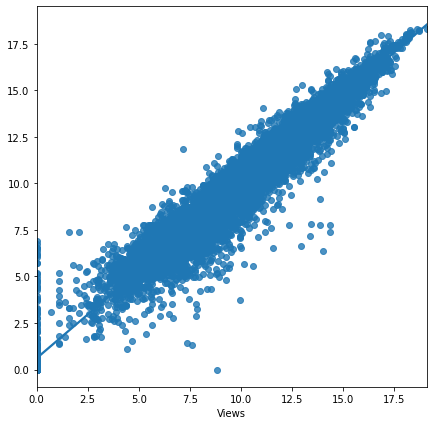

In [56]:
plt.figure(figsize=(7,7))
sns.regplot(x=y_test, y=rf_pred)
plt.show()

In [59]:
score_test = []
rf_kf = RandomForestRegressor()
kf = KFold(n_splits=5, shuffle=False, random_state=None)
for train_index, test_index in kf.split(X_train):
  X_kf_train, X_kf_test = X_train[train_index], X_train[test_index]
  y_kf_train, y_kf_test = y_train.iloc[train_index], y_train.iloc[test_index]

  rf_kf.fit(X_kf_train, y_kf_train)
  score_test.append(rf_kf.score(X_kf_test, y_kf_test))
 
pd.DataFrame(score_test)

test score in kfold {np.mean(score_test)}


,0
0,0.939412
1,0.939521
2,0.939912
3,0.939175
4,0.937852


In [60]:
print(f'mean test score in kfold {np.mean(score_test)}')

test score in kfold 0.9391741146997263


In [61]:
rfkftrain_r2 = rf_kf.score(X_train, y_train)
rfkftest_r2 = rf_kf.score(X_test, y_test)
rmse_reg = -np.sqrt(mean_squared_error(y_test, rf_kf.predict(X_test)))
print(rfkftest_r2)

0.9369741146566729


In [62]:
report.loc[report.shape[0]] = ["Random forest with kfold", rfkftrain_r2, rfkftest_r2, rmse_reg]
report.head()

,name,r2_train,r2_test,rmse
0,Linear regression,0.282505,0.261127,-2.348202
1,Random forest,0.989699,0.941832,-0.658861
2,Random forest with kfold,0.978900,0.936974,-0.685820


In [40]:
baseline_pred = np.full(y_train.shape, y_train.mean())

In [41]:
print('baseline train r2: {}'.format(le.score(X_train, baseline_pred)))

baseline train r2: -6.674179106709851e+29
